$\Large\textbf{Importing libraries and packages}$

In [33]:
import pandas_datareader.data as web
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date
import numpy as np
from scipy.optimize import minimize
plt.style.use('ggplot')

 $\Large\textbf{Inputs}$

\\

$\textbf{Note:}$  

*1.) Please type the all the symbol of the stocks that you want in the following list,* ***symbols***

*2.) Choose a starting date and write it in strings in the following format, yyyy-mm-dd*

*3.) End date is set to today's date. If you want to edit it, type a date in the format described in above point.*

*4.)N_iter : is the number of iteration, or the number of times, portfolio returns and risk is calculated. TYPE A INTEGER VALUE HERE.*

*5.)target_return_arr : is the input while we optimize the portfolio. It is given by the numpy arange method. choose the interval and a freq.* 

In [74]:
symbols = ['AAPL', 'F', 'AAL', 'NFLX', ]

start = '2011-01-01'
end = date.today()

N_iter = 3000
target_return_arr = np.arange(0.005, .0402, .0005)


In [75]:
def get_risk(prices):                                                            #function to calculate risk of given stocks
    return (prices / prices.shift(1) - 1).dropna().std().values

def get_return(prices):                                                          #function to calculate return of a given stocks
    return ((prices / prices.shift(1) - 1).dropna().mean() * np.sqrt(250)).values

def random_weights(n):                                                           # Caclculate weights 
    weights = np.random.rand(n)
    return weights / sum(weights)

def get_portfolio_risk(weights, normalized_prices):                              # Calculate risk on portfolio
    portfolio_val = (normalized_prices * weights).sum(axis=1)
    portfolio = pd.DataFrame(index=normalized_prices.index, data={'portfolio': portfolio_val})
    return (portfolio / portfolio.shift(1) - 1).dropna().std().values[0]

def get_portfolio_return(weights, normalized_prices):                            # Calculate the return on the portfolio
    portfolio_val = (normalized_prices * weights).sum(axis=1)
    portfolio = pd.DataFrame(index=normalized_prices.index, data={'portfolio': portfolio_val})
    ret = get_return(portfolio)
    return ret[0]

def optimize(prices, symbols, target_return=0.1):                                # Optimize the weights on portfolio risk  
    normalized_prices = prices / prices.iloc[0, :]
    init_guess = np.ones(len(symbols)) * (1.0 / len(symbols))
    bounds = ((0.0, 1.0),) * len(symbols)
    weights = minimize(get_portfolio_risk, init_guess,
                       args=(normalized_prices,), method='SLSQP',
                       options={'disp': False},
                       constraints=({'type': 'eq', 'fun': lambda inputs: 1.0 - np.sum(inputs)},
                                    {'type': 'eq', 'args': (normalized_prices,),
                                     'fun': lambda inputs, normalized_prices:
                                     target_return - get_portfolio_return(weights=inputs,
                                                                          normalized_prices=normalized_prices)}),
                       bounds=bounds)
    return weights.x

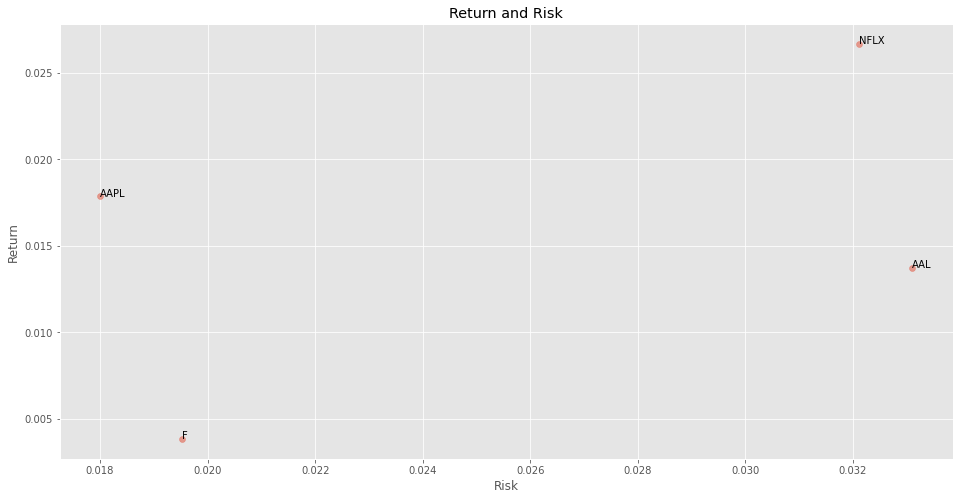

In [76]:
prices = pd.DataFrame(index=pd.date_range(start, end))                          #price df for all the symbols

for symbol in symbols:
    portfolio = web.DataReader(name=symbol, data_source='yahoo', start=start, end=end)
    close = portfolio[['Adj Close']]
    close = close.rename(columns={'Adj Close': symbol})
    prices = prices.join(close)
    portfolio.to_csv("{}.csv".format(symbol))

prices = prices.dropna()
risk_v = get_risk(prices)
return_v = get_return(prices)

fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(x=risk_v, y=return_v, alpha=0.5)
ax.set(title='Return and Risk', xlabel='Risk', ylabel='Return')

for i, symbol in enumerate(symbols):
    ax.annotate(symbol, (risk_v[i], return_v[i]))
plt.show()


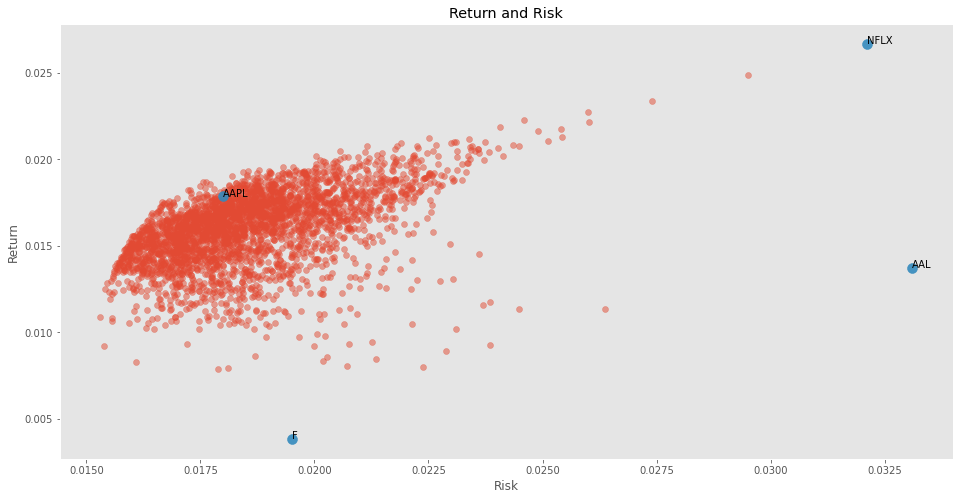

In [77]:
risk_all = np.array([])
return_all = np.array([])


np.random.seed(0)
normalized_prices = prices / prices.iloc[0, :]

for _ in range(0, N_iter):
    weights = random_weights(len(symbols))
    portfolio_val = (normalized_prices * weights).sum(axis=1)
    portfolio = pd.DataFrame(index=prices.index, data={'portfolio': portfolio_val})
    risk = get_risk(portfolio)
    ret = get_return(portfolio)
    risk_all = np.append(risk_all, risk)
    return_all = np.append(return_all, ret)
    p = get_portfolio_risk(weights=weights, normalized_prices=normalized_prices)

fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(x=risk_all, y=return_all, alpha=0.5, cmap='plasma')
ax.set(title='Portfolio Return and Risk', xlabel='Risk', ylabel='Return')

for i, symbol in enumerate(symbols):
    ax.annotate(symbol, (risk_v[i], return_v[i]))

ax.scatter(x=risk_v, y=return_v, alpha=0.9, marker='o', s=100)
ax.set(title='Return and Risk', xlabel='Risk', ylabel='Return')
ax.grid()
plt.show()

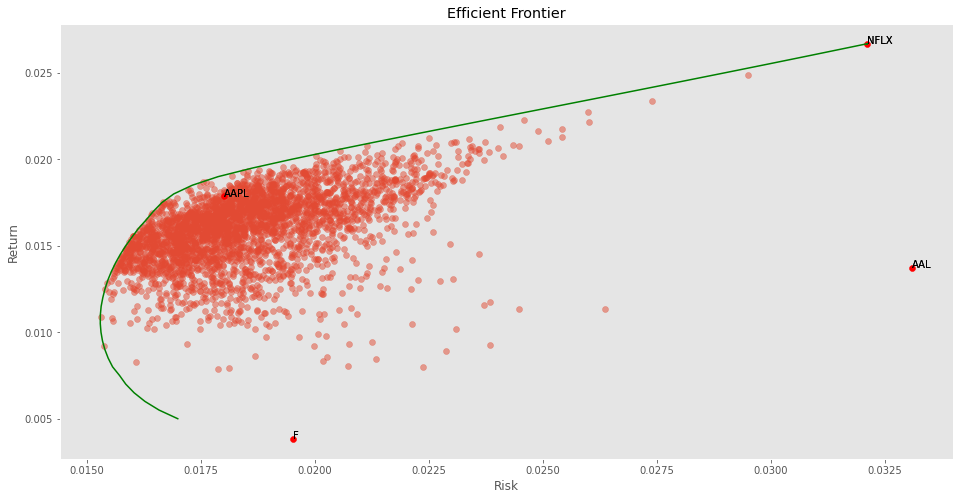

In [78]:
optimal_risk_all = np.array([])
optimal_return_all = np.array([])

for target_return in target_return_arr:
    opt_w = optimize(prices=prices, symbols=symbols, target_return=target_return)
    optimal_risk_all = np.append(optimal_risk_all, get_portfolio_risk(opt_w, normalized_prices))
    optimal_return_all = np.append(optimal_return_all, get_portfolio_return(opt_w, normalized_prices))


fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(x=risk_all, y=return_all, alpha=0.5)

# optimal portfolio risk return
for i, symbol in enumerate(symbols):
    ax.annotate(symbol, (risk_v[i], return_v[i]))

ax.plot(optimal_risk_all, optimal_return_all, '-', color='green')
# symbol risk return
for i, symbol in enumerate(symbols):
    ax.annotate(symbol, (risk_v[i], return_v[i]))

ax.scatter(x=risk_v, y=return_v, color='red')
ax.set(title='Efficient Frontier', xlabel='Risk', ylabel='Return')
ax.grid()
#plt.savefig('return_risk_efficient_frontier.png', bbox_inches='tight')